# SPAM SMS Detection Bahasa Indonesia
Pengguna smartphone di Indonesia seringkali diteror dengan SMS spam yang isinya 'sok akrab' dengan menyebut nama mereka, teman bahkan keluarga terdekat. Padahal, SMS itu datang dari nomor yang tidak dikenal dan berisi pesan atau link untuk masuk dalam situs penipuan. Oleh sebab itu, hal ini membutuhkan solusi agar smartphone kita dapat menyaring SMS penting dari pesan-pesan yang mengganggu dan meresahkan tersebut.

## Tahap 1 - Impor Dataset dan Library yang akan digunakan

download dataset 'http://bit.ly/yw_sms_spam_indonesia'


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [2]:
data = '/content/dataset_sms_spam_v1.csv'
data = pd.read_csv(data)
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [3]:
# data.info()
d = {'Jumlah Record data' : data.value_counts().sum() , 'Jumlah Missing Value' : data.isnull().sum()}
info = pd.DataFrame(data=d)
info

,Jumlah Record data,Jumlah Missing Value
Teks,1143,0
label,1143,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


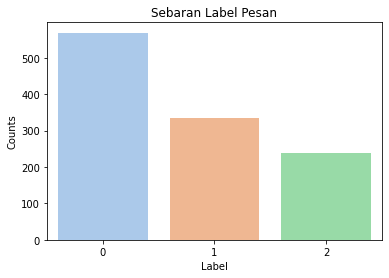

In [4]:
# pesan['label'].value_counts()
sns.countplot(data['label'], palette='pastel')
plt.title("Sebaran Label Pesan")
plt.xlabel("Label")
plt.ylabel("Counts")
plt.show()

In [5]:
# Merubah label dataset
def getlabel(int):
    if int==2:
        return 1
    elif int==1:
        return 1
    else:
        return 0

# membuat kolom baru
data['SMS_Label'] = data['label'].apply(getlabel)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


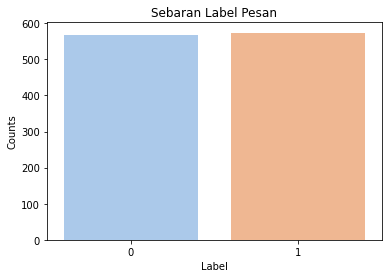

In [6]:
# pesan['SMS_Label'].value_counts()
sns.countplot(data['SMS_Label'], palette='pastel')
plt.title("Sebaran Label Pesan")
plt.xlabel("Label")
plt.ylabel("Counts")
plt.show()

In [7]:
data = data.drop(['label'],axis=1)
data['Pesan'] = data['Teks']

## Tahap 2 - Membersihkan pesan dari karakter (Angka atau Simbol) dan Link 

dengan metode Regular Expression (Regex)

In [8]:
# Proses membersihkan dataset
def Preproces(teks, corpus):
  teks[corpus] = teks[corpus].apply(lambda x: re.sub(r"http\S+", "", x))
  teks[corpus] = teks[corpus].apply(lambda x: re.sub(r"[0-9]", "", x))
  teks[corpus] = teks[corpus].apply(lambda x: re.sub(r"['*&#@/:.,?!]", "", x))
  teks[corpus] = teks[corpus].map(lambda x: x.lower())
  return teks

data = Preproces(data, "Pesan")

In [9]:
# Cek sebelum cleaning data
X = data['Teks'].values
print(X)

# Cek setelah cleaning data
x = data['Pesan'].values
print(x)

['[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'
 '2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat Anda yang terpilih. Aktifkan sekarang juga di *550*905#. Promo sd 30 Nov 2015.Buruan aktifkan sekarang. S&K'
 '2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#'
 ... 'Mba mau kirim 300 ya'
 'nama1  beaok bwrangkat pagi...mau cas atay tranfer?'
 'No bri atas nama kamu mana']
['[promo] beli paket flash mulai gb di my telkomsel app dpt extra kuota gb g lte dan extra nelpon hingga mnthr buruan cek  di tselmemytsel sk'
 ' gb hari hanya rp  ribu spesial buat anda yang terpilih aktifkan sekarang juga di  promo sd  nov buruan aktifkan sekarang sk'
 '-- plg yth sisa kuota flash anda kb download mytelkomsel apps di  utk cek kuotabeli paket flash atau hub '
 ... 'mba mau kirim  ya' 'nama  beaok

In [10]:
data = data.drop(['Teks'],axis=1)
data.head()

,SMS_Label,Pesan
0,1,[promo] beli paket flash mulai gb di my telkom...
1,1,gb hari hanya rp ribu spesial buat anda yang...
2,1,-- plg yth sisa kuota flash anda kb download m...
3,1,-- plg yth sisa kuota flash anda kb download m...
4,1,gb hari hanya rp ribu spesial buat anda yang ...


### Membuat Visualisasi Teks dalam Gambar dengan WordCloud

In [11]:
Bukan_SMS_SPAM = data[data.SMS_Label ==0]
SMS_SPAM = data[data.SMS_Label==1]

Bukan_SMS_SPAM_Teks = " ".join(Bukan_SMS_SPAM.Pesan.to_numpy().tolist())
SMS_SPAM_Teks = " ".join(SMS_SPAM.Pesan.to_numpy().tolist())

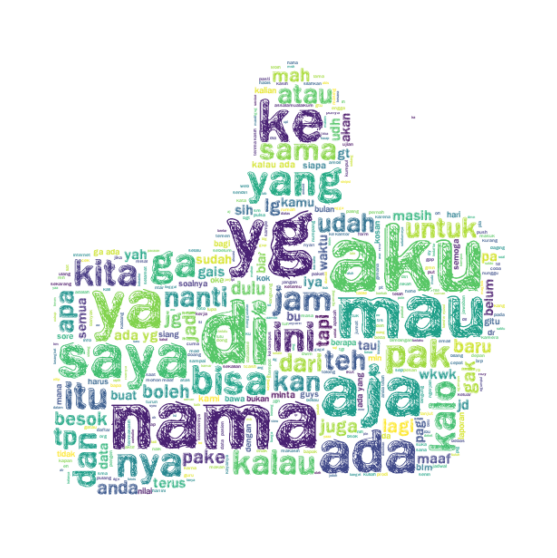

In [12]:
mask = np.array(Image.open('/content/thumb.jpg'))
# wordcloud pesan penting
pesan_cloud = WordCloud(font_path='/content/vtks giz.ttf',
               mask=mask, background_color="white",
               max_words=2000, max_font_size=100,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0]).generate(Bukan_SMS_SPAM_Teks)
plt.figure(figsize=(15,10))
plt.imshow(pesan_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

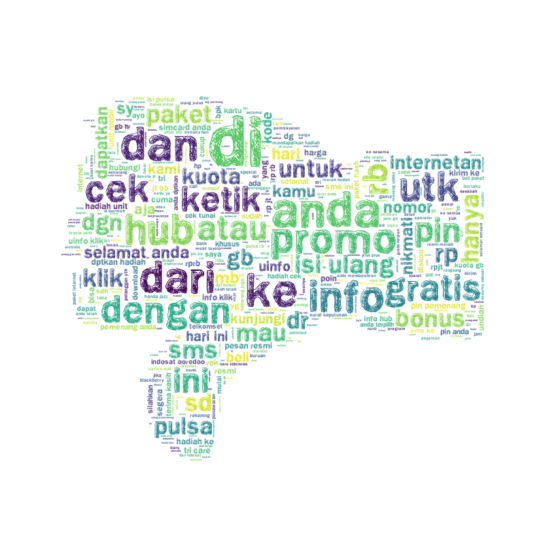

In [13]:
mask = np.array(Image.open('/content/dislike.jpg'))
# wordcloud pesan spam
spam_cloud = WordCloud(font_path='/content/vtks giz.ttf',
               mask=mask, background_color="white",
               max_words=2000, max_font_size=100,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0]).generate(SMS_SPAM_Teks)
plt.figure(figsize=(15,10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

## Tahap 3 - Preprocesing dalam NLP 
Tahap ini terdiri dari beberapa proses, antara lain: membagi dataset menjadi data training untuk melatih model dan data testing untuk menguji model. Selanjutnya agar komputer dapat memahami bahasa yang kita gunakan maka harus diubah menjadi bentuk angka.

In [14]:
# Definisi hyperparameters untuk pre-processing 
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(data['Pesan'])
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'di': 2, 'anda': 3, 'ke': 4, 'ini': 5, 'info': 6, 'ada': 7, 'yg': 8, 'aku': 9, 'pin': 10, 'mau': 11, 'dan': 12, 'hadiah': 13, 'dari': 14, 'no': 15, 'sms': 16, 'cek': 17, 'rp': 18, 'klik': 19, 'nama': 20, 'aja': 21, 'pulsa': 22, 'paket': 23, 'hub': 24, 'gb': 25, 'ya': 26, 'saya': 27, 'yang': 28, 'hari': 29, 'untuk': 30, 'jt': 31, 'rb': 32, 'promo': 33, 'resmi': 34, 'atau': 35, 'pemenang': 36, 'bisa': 37, 'selamat': 38, 'isi': 39, 'utk': 40, 'kalau': 41, 'jam': 42, 'dr': 43, 'dengan': 44, 'tri': 45, 'uinfo': 46, 'nya': 47, 'kamu': 48, 'ga': 49, 'kuota': 50, 'm': 51, 'gratis': 52, 'sd': 53, 'ketik': 54, 'care': 55, 'ulang': 56, 'bonus': 57, 'hanya': 58, 'sudah': 59, 'pak': 60, 'berlaku': 61, 'beli': 62, 'dgn': 63, 'indosat': 64, 'bb': 65, 'juga': 66, 'dptkan': 67, 'maaf': 68, 'kita': 69, 'itu': 70, 'kalo': 71, 'dpt': 72, 'sama': 73, 'nanti': 74, 'kirim': 75, 'mobil': 76, 'telah': 77, 'g': 78, 'undian': 79, 'kasih': 80, 'flash': 81, 'yth': 82, 'internet': 83, 'kami': 84, 'seka

In [16]:
total_kata = len(word_index)
print('Sebanyak %s kata unik dalam data training. ' % total_kata)

Sebanyak 4460 kata unik dalam data training. 


In [17]:
list_sequences = tokenizer.texts_to_sequences(data['Pesan'])
list_padded = pad_sequences (list_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

In [18]:
print(data['Pesan'])

0       [promo] beli paket flash mulai gb di my telkom...
1        gb hari hanya rp  ribu spesial buat anda yang...
2       -- plg yth sisa kuota flash anda kb download m...
3       -- plg yth sisa kuota flash anda kb download m...
4       gb hari hanya rp  ribu spesial buat anda yang ...
                              ...                        
1138         yooo sama oke nanti aku umumin di grup kelas
1139    😁 sebelumnya ga ad nulis kerudung kirain warna...
1140                                    mba mau kirim  ya
1141       nama  beaok bwrangkat pagimau cas atay tranfer
1142                           no bri atas nama kamu mana
Name: Pesan, Length: 1143, dtype: object


In [19]:
print(list_sequences[0])
print(list_padded[0])

[33, 62, 23, 81, 110, 25, 2, 416, 138, 255, 72, 190, 50, 25, 78, 287, 12, 190, 122, 191, 1, 148, 17, 2, 417, 192]
[ 33  62  23  81 110  25   2 416 138 255  72 190  50  25  78 287  12 190
 122 191   1 148  17   2 417 192   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [20]:
label = data['SMS_Label'].values
train_teks, test_teks, train_label, test_label = train_test_split(data['Pesan'], label, test_size=0.2, random_state=434)

In [21]:
training_sequences = tokenizer.texts_to_sequences(train_teks)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_teks)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

## Tahap 4 - Membuat Model 
Algoritma yang digunakan adalah model deeplearning menggunakan tensorflow.

In [22]:
# Definisi hyperparameter model
vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

# Model 1 - Dense Arsitektur
model_1 = Sequential()
model_1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model_1.add(GlobalAveragePooling1D())
model_1.add(Dense(24, activation='relu'))
model_1.add(Dropout(drop_value))
model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


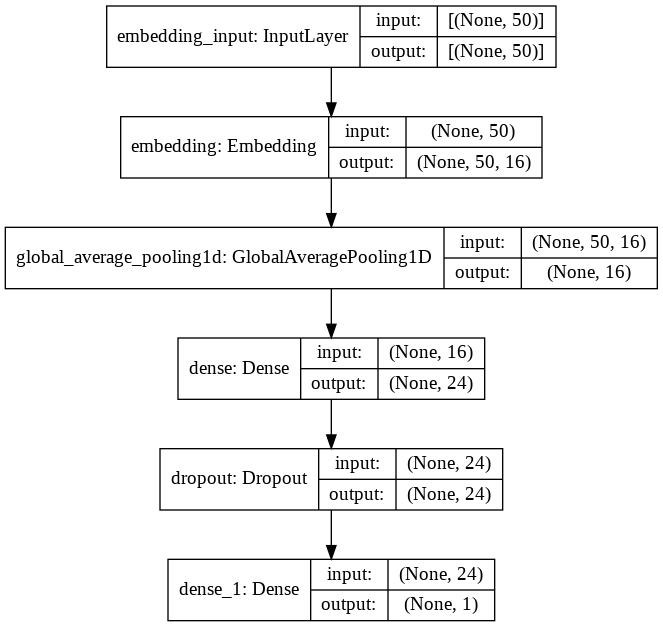

In [23]:
# Contoh model architecture plot
from tensorflow.keras.utils import plot_model
# summarize model 1
plot_model(model_1, 'model_1_summary.png', show_shapes=True)

In [24]:
# Parameter training model 1
model_1.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

# proses training model 1 menggunakan dataset training dan testing
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_1 = model_1.fit(training_padded, train_label, epochs=30, validation_data=(testing_padded, test_label),callbacks =[early_stop], verbose=2)

Epoch 1/30
29/29 - 1s - loss: 0.6896 - accuracy: 0.6575 - val_loss: 0.6863 - val_accuracy: 0.7031
Epoch 2/30
29/29 - 0s - loss: 0.6760 - accuracy: 0.8359 - val_loss: 0.6679 - val_accuracy: 0.8690
Epoch 3/30
29/29 - 0s - loss: 0.6518 - accuracy: 0.8917 - val_loss: 0.6363 - val_accuracy: 0.8646
Epoch 4/30
29/29 - 0s - loss: 0.6068 - accuracy: 0.9256 - val_loss: 0.5873 - val_accuracy: 0.8646
Epoch 5/30
29/29 - 0s - loss: 0.5377 - accuracy: 0.9289 - val_loss: 0.5174 - val_accuracy: 0.8734
Epoch 6/30
29/29 - 0s - loss: 0.4560 - accuracy: 0.9300 - val_loss: 0.4380 - val_accuracy: 0.8865
Epoch 7/30
29/29 - 0s - loss: 0.3742 - accuracy: 0.9387 - val_loss: 0.3702 - val_accuracy: 0.8952
Epoch 8/30
29/29 - 0s - loss: 0.3049 - accuracy: 0.9431 - val_loss: 0.3140 - val_accuracy: 0.9127
Epoch 9/30
29/29 - 0s - loss: 0.2556 - accuracy: 0.9442 - val_loss: 0.2732 - val_accuracy: 0.9127
Epoch 10/30
29/29 - 0s - loss: 0.2086 - accuracy: 0.9519 - val_loss: 0.2469 - val_accuracy: 0.9039
Epoch 11/30
29/29 -

In [25]:
# Definisi hyperparameters LSTM 
n_lstm = 20
drop_lstm =0.2

# Model 2 - Arsitektur LSTM
model_2 = Sequential()
model_2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model_2.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model_2.add(LSTM(n_lstm, dropout=drop_lstm))
model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
lstm (LSTM)                  (None, 50, 20)            2960      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________


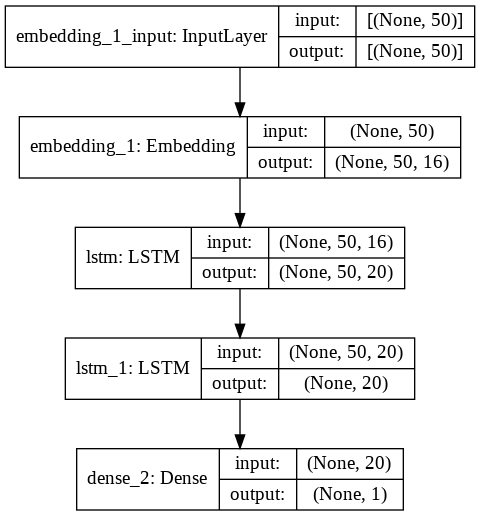

In [26]:
# Contoh model architecture plot
from tensorflow.keras.utils import plot_model
# summarize model 2
plot_model(model_2, 'model_1_summary.png', show_shapes=True)

In [27]:
# Parameter training model 2
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# proses training model 2 menggunakan dataset training dan testing
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_2 = model_2.fit(training_padded, train_label, epochs=30, validation_data=(testing_padded, test_label),callbacks =[early_stop], verbose=2)

Epoch 1/30
29/29 - 6s - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6945 - val_accuracy: 0.4629
Epoch 2/30
29/29 - 1s - loss: 0.6932 - accuracy: 0.5142 - val_loss: 0.6915 - val_accuracy: 0.4760
Epoch 3/30
29/29 - 1s - loss: 0.5263 - accuracy: 0.7637 - val_loss: 0.2881 - val_accuracy: 0.9127
Epoch 4/30
29/29 - 1s - loss: 0.1906 - accuracy: 0.9530 - val_loss: 0.2405 - val_accuracy: 0.9301
Epoch 5/30
29/29 - 1s - loss: 0.1419 - accuracy: 0.9650 - val_loss: 0.2273 - val_accuracy: 0.9301
Epoch 6/30
29/29 - 1s - loss: 0.1055 - accuracy: 0.9748 - val_loss: 0.2409 - val_accuracy: 0.9345
Epoch 7/30
29/29 - 1s - loss: 0.0943 - accuracy: 0.9770 - val_loss: 0.1939 - val_accuracy: 0.9476
Epoch 8/30
29/29 - 1s - loss: 0.0641 - accuracy: 0.9880 - val_loss: 0.1825 - val_accuracy: 0.9520
Epoch 9/30
29/29 - 1s - loss: 0.0694 - accuracy: 0.9858 - val_loss: 0.1822 - val_accuracy: 0.9432
Epoch 10/30
29/29 - 1s - loss: 0.0678 - accuracy: 0.9836 - val_loss: 0.2186 - val_accuracy: 0.9389
Epoch 11/30
29/29 -

In [28]:
# Model 3 - Bi-directional Long Short Term Memory (BiLSTM) Arsitektur
model_3 = Sequential()
model_3.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model_3.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model_3.add(LSTM(n_lstm, dropout=drop_lstm))
model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 18,821
Trainable params: 18,821
Non-trainable params: 0
_________________________________________________________________


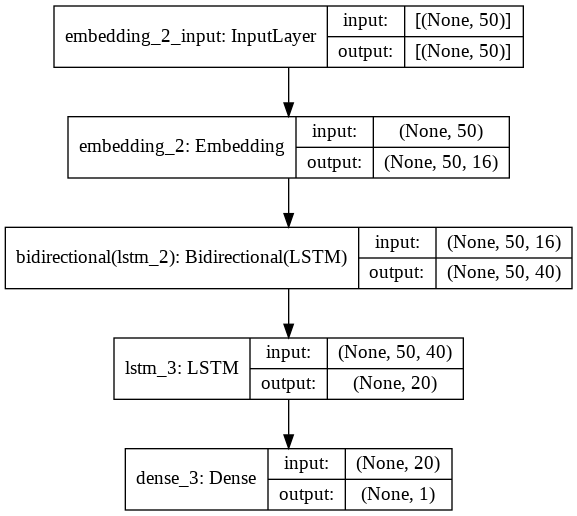

In [29]:
# Contoh model architecture plot
from tensorflow.keras.utils import plot_model
# summarize model 3
plot_model(model_3, 'model_1_summary.png', show_shapes=True)

In [30]:
# Parameter training model 3
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# proses training model 3 menggunakan dataset training dan testing
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_3 = model_3.fit(training_padded, train_label, epochs=30, 
                    validation_data=(testing_padded, test_label),callbacks =[early_stop], verbose=2)

Epoch 1/30
29/29 - 8s - loss: 0.6939 - accuracy: 0.4737 - val_loss: 0.6933 - val_accuracy: 0.4629
Epoch 2/30
29/29 - 1s - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6951 - val_accuracy: 0.4629
Epoch 3/30
29/29 - 1s - loss: 0.6933 - accuracy: 0.5197 - val_loss: 0.6937 - val_accuracy: 0.4629
Epoch 4/30
29/29 - 1s - loss: 0.5503 - accuracy: 0.7243 - val_loss: 0.3533 - val_accuracy: 0.8952
Epoch 5/30
29/29 - 1s - loss: 0.2299 - accuracy: 0.9431 - val_loss: 0.2206 - val_accuracy: 0.9432
Epoch 6/30
29/29 - 1s - loss: 0.1426 - accuracy: 0.9683 - val_loss: 0.2626 - val_accuracy: 0.9214
Epoch 7/30
29/29 - 1s - loss: 0.1098 - accuracy: 0.9759 - val_loss: 0.1970 - val_accuracy: 0.9258
Epoch 8/30
29/29 - 1s - loss: 0.0890 - accuracy: 0.9814 - val_loss: 0.2302 - val_accuracy: 0.9432
Epoch 9/30
29/29 - 1s - loss: 0.0715 - accuracy: 0.9869 - val_loss: 0.1995 - val_accuracy: 0.9476
Epoch 10/30
29/29 - 1s - loss: 0.0781 - accuracy: 0.9847 - val_loss: 0.1989 - val_accuracy: 0.9476


## Tahap 5 - Evaluasi Hasil Akurasi dan Loss setiap Model
Confusion Matrix adalah pengukuran performa untuk masalah klasifikasi machine learning dimana keluaran dapat berupa True Positif, True Negatif, False Positif, dan False Negatif. 

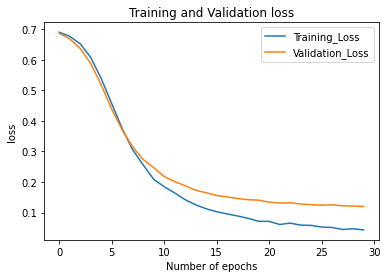

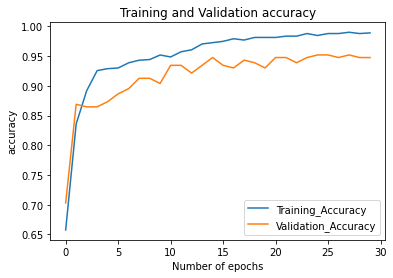

In [32]:
# Visualisasi hasil training dan testing model 1
metrics = pd.DataFrame(history_1.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [33]:
# Evaluasi performa model 1
predicted_1 = model_1.predict(testing_padded)
arr_1 = np.array(predicted_1)
output_1 = np.round(arr_1).astype(int)
print("Classification Report")
print(classification_report(test_label, output_1))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       105
           1       0.94      0.96      0.95       124

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229



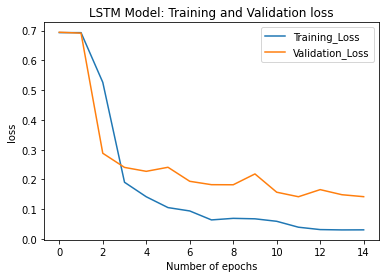

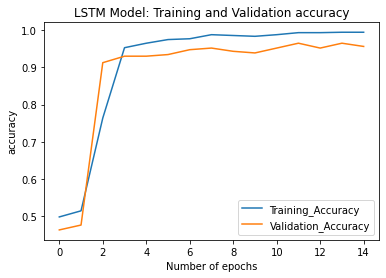

In [34]:
# Visualisasi hasil training dan testing model 2
metrics = pd.DataFrame(history_2.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [35]:
# Evaluasi performa model 2
predicted_2 = model_2.predict(testing_padded)
arr_2 = np.array(predicted_2)
output_2 = np.round(arr_2).astype(int)

print("Classification Report")
print(classification_report(test_label, output_2))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       105
           1       0.96      0.96      0.96       124

    accuracy                           0.96       229
   macro avg       0.96      0.96      0.96       229
weighted avg       0.96      0.96      0.96       229



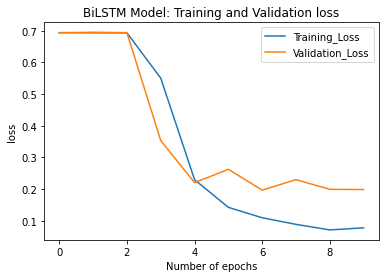

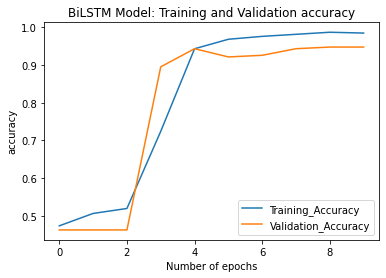

In [31]:
# Visualisasi hasil training dan testing model 3
metrics = pd.DataFrame(history_3.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [36]:
# Evaluasi performa model 3
predicted_3 = model_3.predict(testing_padded)
arr_3 = np.array(predicted_3)
output_3 = np.round(arr_3).astype(int)
print("Classification Report")
print(classification_report(test_label, output_3))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       105
           1       0.92      0.98      0.95       124

    accuracy                           0.95       229
   macro avg       0.95      0.94      0.95       229
weighted avg       0.95      0.95      0.95       229



In [ ]:
# cm = confusion_matrix(test_label, output)
# fig, ax = plt.subplots()
# fig.set_size_inches(12, 8)
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
# ax.set(xticklabels=test_label, yticklabels=test_label, title="Confusion matrix")
# ax.tick_params(axis='x', labelsize=16)
# ax.tick_params(axis='y', labelsize=16)
# ax.set_ylabel("True", color="royalblue", fontsize=20, fontweight=700)
# ax.set_xlabel("Prediction", color="royalblue", fontsize=20, fontweight=700)
# plt.yticks(rotation=0);

In [37]:
# Perbandingan performansi 3 Model Training
print(f"\nDense architecture loss and accuracy: {model_1.evaluate(testing_padded, test_label)} " )
print(f"\nLSTM architecture loss and accuracy: {model_2.evaluate(testing_padded, test_label)} " )
print(f"\nBi-LSTM architecture loss and accuracy: {model_3.evaluate(testing_padded, test_label)} " )

8/8 [==============================] - 0s 3ms/step - loss: 0.1201 - accuracy: 0.9476

Dense architecture loss and accuracy: [0.12006565928459167, 0.9475982785224915] 
8/8 [==============================] - 0s 10ms/step - loss: 0.1422 - accuracy: 0.9563

LSTM architecture loss and accuracy: [0.14218798279762268, 0.9563318490982056] 
8/8 [==============================] - 0s 13ms/step - loss: 0.1989 - accuracy: 0.9476

Bi-LSTM architecture loss and accuracy: [0.1988939791917801, 0.9475982785224915] 


## Tahap 6 - Prediksi menggunakan Pesan Baru

In [38]:
# Fungsi prediksi
def prediksi_spam_1(prediksi_teks_1):
    new_seq_1 = tokenizer.texts_to_sequences(prediksi_teks_1)
    padded_1 = pad_sequences(new_seq_1, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model_1.predict(padded_1))

def prediksi_spam_2(prediksi_teks_2):
    new_seq_2 = tokenizer.texts_to_sequences(prediksi_teks_2)
    padded_2 = pad_sequences(new_seq_2, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model_2.predict(padded_2))

def prediksi_spam_3(prediksi_teks_3):
    new_seq_3 = tokenizer.texts_to_sequences(prediksi_teks_3)
    padded_3 = pad_sequences(new_seq_3, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model_3.predict(padded_3))

In [39]:
# Tuliskan teks spam (penipuan atau promosi) nilainya mendekati 1
Pesan_baru = ["silahkan untuk mengambil hadiah dengan memasukan kode unik 2345. Anda berhasil menang undian berhadiah mobil"]

print(f"\nHasil prediksi berdasarkan model Dense Network: {prediksi_spam_1(Pesan_baru)} " )
print(f"\nHasil prediksi berdasarkan model LSTM: {prediksi_spam_2(Pesan_baru)} " )
print(f"\nHasil prediksi berdasarkan model Bi-LSTM: {prediksi_spam_3(Pesan_baru)} " )


Hasil prediksi berdasarkan model Dense Network: [[0.90205973]] 

Hasil prediksi berdasarkan model LSTM: [[0.9919783]] 

Hasil prediksi berdasarkan model Bi-LSTM: [[0.9785824]] 


In [40]:
# Tuliskan teks penting nilainya < 0
Pesan_baru = ["Kak saya izin mau asistensi laporan, modul 5"]

print(f"\nHasil prediksi berdasarkan model Dense Network: {prediksi_spam_1(Pesan_baru)} " )
print(f"\nHasil prediksi berdasarkan model LSTM: {prediksi_spam_2(Pesan_baru)} " )
print(f"\nHasil prediksi berdasarkan model Bi-LSTM: {prediksi_spam_3(Pesan_baru)} " )


Hasil prediksi berdasarkan model Dense Network: [[0.01486099]] 

Hasil prediksi berdasarkan model LSTM: [[0.00831453]] 

Hasil prediksi berdasarkan model Bi-LSTM: [[0.01586533]] 


In [ ]:
# d = {'Pesan' : test_teks, 'Label' : test_label, 'Prediksi' : output}
# hasil_model_1 = pd.DataFrame(data=d)
# hasil_model_1.head()

## Tahap 7 - Menyimpan Model 
simpan model agar dapat di implementasikan pada perangkat atau dimanfaatkan lebih lanjut.

In [42]:
model_1.save('spam_SMS_v1.h5')

In [43]:
model_2.save('spam_SMS_v2.h5')

In [44]:
model_3.save('spam_SMS_v3.h5')